# FIFA : Position Area & Overall Prediction Model

Dalam permainan di FIFA 20 Ultimate Team, setiap pemain memiliki nilai overall yang skalanya 0-99 dan overall ini ditentukan dari skill yang terdiri dari pace, dribbling, shooting, passing, defending, physicality. Sedangkan goalkeeper tidak memiliki kemampuan ini, seorang goalkeeper memiliki kemampuan sendiri seperti reflexes, diving, kick, dan masih banyak lagi. Skill-skill ini merupakan nilai keseluruhan yang ditentukan oleh fifa berdasarkan subskillnya. Sehingga dalam hal ini kita akan melakukan prediksi dengan features yang telah disebutkan. Kemudian melihat correlation dan pengaruh terhadap overall.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Lenovo\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.2, the latest is 0.3.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
fifa=pd.read_csv('fut_bin20_players.csv')
fifa.drop(['futbin_id','specialities','origin'], axis=1, inplace=True)
fifa=pd.get_dummies(data=fifa, drop_first=True, columns=['pref_foot'])
fifa.info()

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18775 entries, 0 to 18774
Data columns (total 92 columns):
player_name             18775 non-null object
player_extended_name    18775 non-null object
quality                 18775 non-null object
revision                18409 non-null object
overall                 18775 non-null int64
club                    18775 non-null object
league                  18775 non-null object
nationality             18775 non-null object
position                18775 non-null object
age                     18775 non-null int64
date_of_birth           18775 non-null object
height                  18775 non-null int64
weight                  18775 non-null int64
intl_rep                17047 non-null float64
added_date              18775 non-null object
pace                    16791 non-null float64
pace_acceleration       18672 non-null float64
pace_sprint_speed       18672 non-null float64
dribbling               16791 non-null float64
drib_agility    

# Functions
Berikut merupakan fungsi-fungsi yang telah dibuat dengan tujuan cleaning data.

In [3]:
# Untuk membuat kolom baru berupa 'position_area' yang berisi tentang posisi area pemain.
def area(col):
    if col=='ST' or col=='CF':
        return 'Center Forward'
    elif col=='LW' or col=='RW' or col=='RF' or col=='LF':
        return 'Wing Forward'
    elif col=='RM' or col=='LM':
        return 'Wing Middle'
    elif col=='CAM' or col=='CM' or col=='CDM':
        return 'Center Middle'
    elif col=='LB' or col=='RB' or col=='RWB' or col=='LWB':
        return 'Wing Back'
    elif col=='CB':
        return 'Center Back'
    else:
        return 'Goalkeeper'

# Menghilangkan kata '- Rare' dalam kolom quality. 
def quality(col):
    if 'Gold' in col:
        return 'Gold'
    elif 'Silver' in col:
        return 'Silver'
    elif 'Bronze' in col:
        return 'Bronze'
    else:
        return col

# bootstrap algorithm dengan tujuan melihat range nilai.
def make_bootstrap(boot,data,req):
    ci=0.95
    last=[]
    n=len(data)
    for i in range(boot):
        sampling=data.sample(n, replace=True)
        last.append(sampling.mean())
    isi=np.sort(np.array(last))
    level=((1-ci)/2)
    atas=1-level
    batas=[isi[round(level*boot)], isi[round(atas*boot)]]
    if req=='isi':
        return last
    else:
        return batas
    
# Melihat data-data null untuk setiap featurenya.
def nullity(data):
    df=pd.DataFrame(columns=['dataFeatures','dataType','null','nullPct','unique','uniqueSample'])
    df['dataFeatures']=data.columns
    df['dataType']=[i for i in data.dtypes]
    df['null']=df['dataFeatures'].apply(lambda x: sum(data[x].isna()))
    df['nullPct']=df['null'].apply(lambda x: round((x/len(data))*100,2))
    df['unique']=df['dataFeatures'].apply(lambda x: len(data[~(data[x].isna())][x].unique()))
    return df

def correlation_ratio(categories, measurements):
    fcat, _=pd.factorize(categories)
    cat_num=np.max(fcat)+1
    y_avg_array=np.zeros(cat_num)
    n_array=np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures=measurements[np.argwhere(fcat==i).flatten()]
        n_array[i]=len(cat_measures)
        y_avg_array[i]=np.average(cat_measures)
    y_total_avg=np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator=np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator=np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator==0:
        eta=0.0
    else:
        eta=np.sqrt(numerator/denominator)
    return eta

def cramers_v(x,y):
    import scipy.stats as ss
    confusion_matrix=pd.crosstab(x,y)
    chi2=ss.chi2_contingency(confusion_matrix)[0]
    n=confusion_matrix.sum().sum()
    phi2=chi2/n
    r,k=confusion_matrix.shape
    phi2corr=max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr=r-((r-1)**2)/(n-1)
    kcorr=k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Data Cleaning

In [4]:
# mengambil nama-nama kolom yang akan digunakkan untuk prediksi.
everything=['pref_foot_Right','skill_moves','intl_rep']

for i in fifa.select_dtypes(exclude='object'):
    if ('drib' in i) or ('pace' in i) or ('shoot' in i) or ('gk_' in i) or ('pass' in i) or ('drib' in i) or ('def' in i) or ('phys' in i):
        everything.append(i)
everything

['pref_foot_Right',
 'skill_moves',
 'intl_rep',
 'pace',
 'pace_acceleration',
 'pace_sprint_speed',
 'dribbling',
 'drib_agility',
 'drib_balance',
 'drib_reactions',
 'drib_ball_control',
 'drib_dribbling',
 'drib_composure',
 'shooting',
 'shoot_positioning',
 'shoot_finishing',
 'shoot_shot_power',
 'shoot_long_shots',
 'shoot_volleys',
 'shoot_penalties',
 'passing',
 'pass_vision',
 'pass_crossing',
 'pass_free_kick',
 'pass_short',
 'pass_long',
 'pass_curve',
 'defending',
 'def_interceptions',
 'def_heading',
 'def_marking',
 'def_stand_tackle',
 'def_slid_tackle',
 'physicality',
 'phys_jumping',
 'phys_stamina',
 'phys_strength',
 'phys_aggression',
 'gk_diving',
 'gk_reflexes',
 'gk_handling',
 'gk_speed',
 'gk_kicking',
 'gk_positoning']

In [5]:
print(nullity(fifa)[:41])
print(nullity(fifa)[41:])

            dataFeatures dataType  null  nullPct  unique uniqueSample
0            player_name   object     0     0.00   12968          NaN
1   player_extended_name   object     0     0.00   16383          NaN
2                quality   object     0     0.00       6          NaN
3               revision   object   366     1.95      53          NaN
4                overall    int64     0     0.00      52          NaN
5                   club   object     0     0.00     653          NaN
6                 league   object     0     0.00      45          NaN
7            nationality   object     0     0.00     159          NaN
8               position   object     0     0.00      17          NaN
9                    age    int64     0     0.00      53          NaN
10         date_of_birth   object     0     0.00    6036          NaN
11                height    int64     0     0.00      50          NaN
12                weight    int64     0     0.00      56          NaN
13              intl

Dapat dilihat terdapat data-data yang nilainya null hal inin dikarenakan skill yang dimiliki pemain biasa tidak dimiliki goalkeeper dan sebaliknya. Kemudian, saya mengganti nilai null ini dengan nilai 0

In [6]:
# Filling the null value
gk=[]
players=[]

for i in everything:
    if 'gk_' in i:
        gk.append(i)
    else:
        players.append(i)
        
for i in gk:
    fifa[i]=fifa[i].apply(lambda x: 0 if pd.isna(x) else x)    
for i in players:
    fifa[i]=fifa[i].apply(lambda x: 0 if pd.isna(x) else x)

In [7]:
fifa['traits']=fifa['traits'].apply(lambda x: '' if pd.isna(x) else x)
fifa['traits']

0        Solid Player, Leadership, Finesse Shot, Playma...
1        Finesse Shot, Flair, Playmaker (CPU AI Only), ...
2        Finesse Shot, Speed Dribbler (CPU AI Only), Ch...
3                                                         
4        Technical Dribbler (CPU AI Only), Chip Shot, P...
                               ...                        
18770    Technical Dribbler (CPU AI Only), Outside Foot...
18771    Technical Dribbler (CPU AI Only), Outside Foot...
18772    Technical Dribbler (CPU AI Only), Speed Dribbl...
18773                                                     
18774    Speed Dribbler (CPU AI Only), Flair, Finesse Shot
Name: traits, Length: 18775, dtype: object

In [8]:
print(fifa['quality'])

fifa['quality']=fifa['quality'].apply(quality)
fifa['position_area']=fifa['position'].apply(area)
fifa['intl_rep']=fifa['intl_rep'].apply(lambda x: 0 if pd.isna(x) else x)

0        Gold - Rare
1        Gold - Rare
2        Gold - Rare
3        Gold - Rare
4        Gold - Rare
            ...     
18770    Gold - Rare
18771    Gold - Rare
18772    Gold - Rare
18773    Gold - Rare
18774    Gold - Rare
Name: quality, Length: 18775, dtype: object


Terdapat kolom traits yang berisikan tentang julukan yang dimiliki pemain. Semua julukkan ini akan dijadikkan dummies supaya dapat dijadikan features yang diprediksi.

In [9]:
# Mengganti text yang ada di traits displit dengan ',' dan menjadikkan dummies
traits_split=fifa['traits'].apply(lambda x: x if pd.isna(x) else x.split(','))
traits=[]
for i in traits_split:
    try :
        for j in i:
            traits.append(j)
    except :
        pass

In [10]:
traits_bersih=[]
for i in traits:
    if i=='':
        continue
    if i[0]==' ':
        if i==' Comes For Crosses':
            traits_bersih.append('Comes for Crosses')
        else:
            traits_bersih.append(i[1:])
        continue
    traits_bersih.append(i)
jenis=pd.Series(traits_bersih).unique()
jenis

array(['Solid Player', 'Leadership', 'Finesse Shot',
       'Playmaker (CPU AI Only)', 'Technical Dribbler (CPU AI Only)',
       'Flair', 'Chip Shot (CPU AI Only)', 'Speed Dribbler (CPU AI Only)',
       'Chip Shot', 'Dives Into Tackles (CPU AI Only)', 'Team Player',
       'Power Free-Kick', 'Long Shot Taker (CPU AI Only)', 'Power Header',
       'Long Passer (CPU AI Only)', 'Outside Foot Shot', 'GK Long Throw',
       'Comes for Crosses', 'Early Crosser', 'Injury Prone',
       'Long Throw-In', 'Set Play Specialist', 'Rushes out of Goal',
       'Cautious with Crosses', 'Saves with Feet', 'One Club Player',
       'Giant Throw-in'], dtype=object)

In [11]:
for i in jenis:
    fifa[i]=fifa['traits'].apply(lambda x: 1 if i in x else 0 )

# Exploratory Data Analysis

GOLD :
Max 99
Min 75

SILVER :
Max 74
Min 65

BRONZE :
Max 64
Min 48



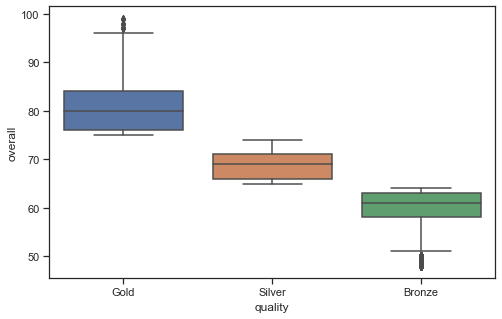

In [12]:
# Melihat range overall untuk setiap quality
for i in fifa['quality'].unique():
    print(i.upper()+' :')
    print('Max {}\nMin {}\n'.format(fifa[fifa['quality']==i]['overall'].max(), fifa[fifa['quality']==i]['overall'].min()))

plt.figure(figsize=(8,5))
sns.boxplot(data=fifa, x='quality', y='overall')
sns.set_style(style='darkgrid')

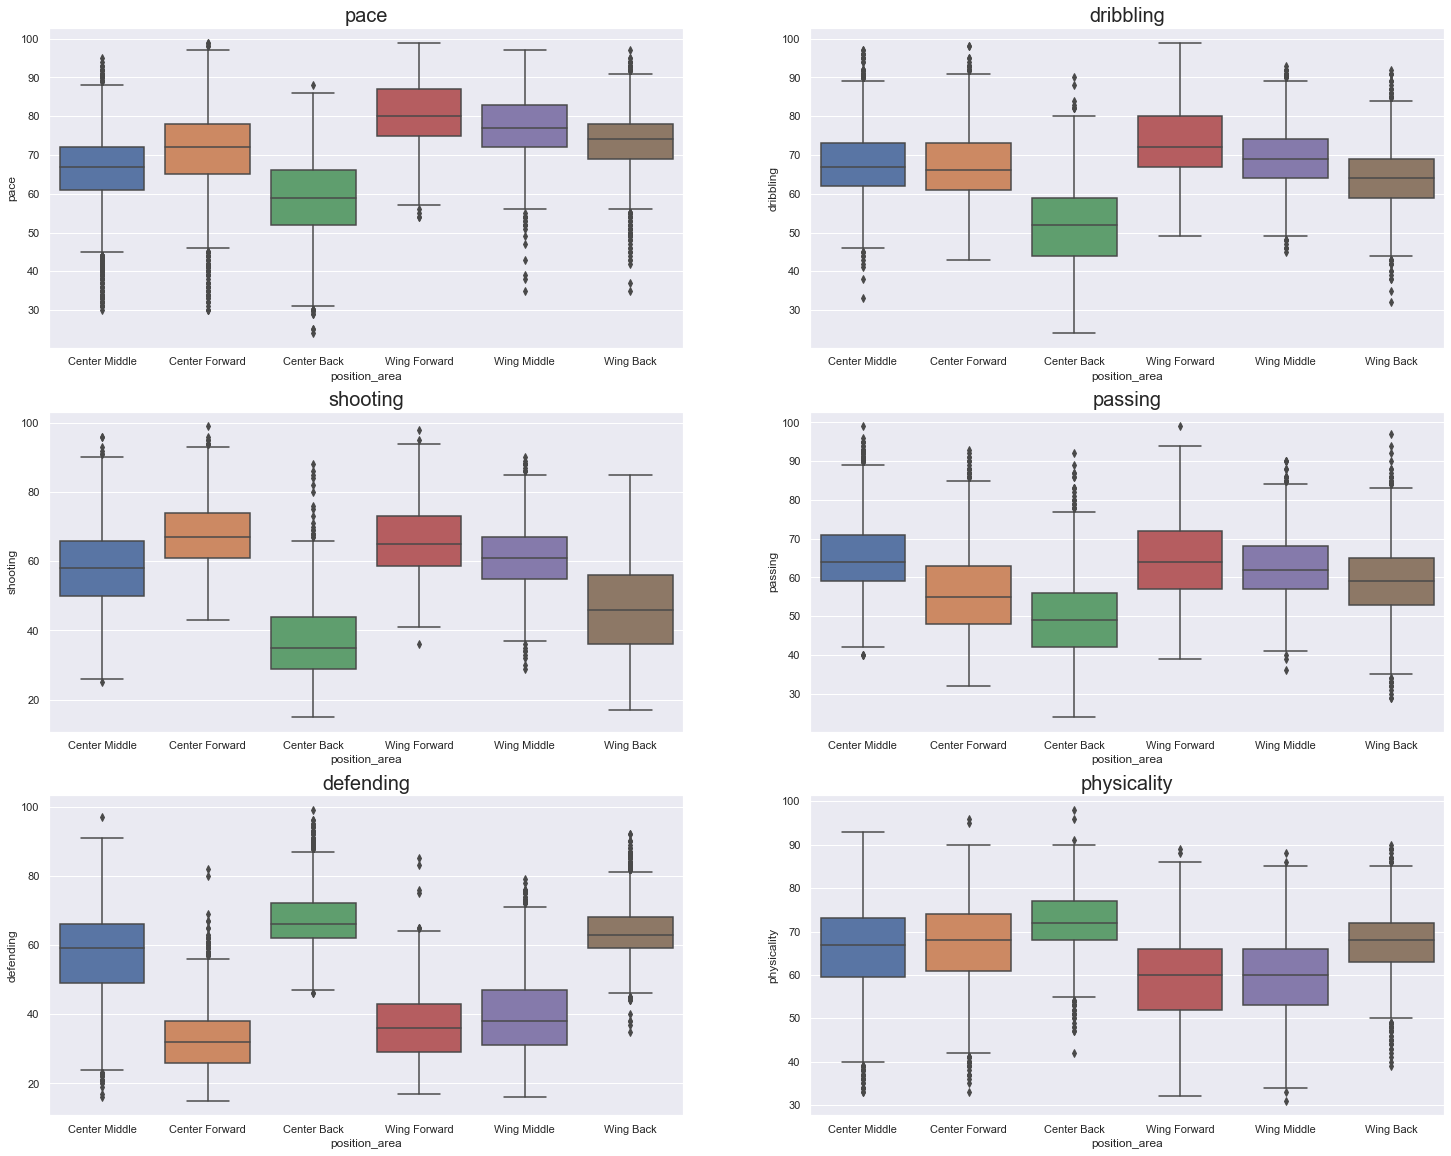

In [13]:
# Melihat Range skill untuk setiap posisi area
skill=['pace','dribbling','shooting','passing','defending','physicality']
plt.figure(figsize=(25,20))
for i,j in enumerate(skill):
    plt.subplot(3,2,i+1)
    sns.boxplot(data=fifa[fifa['position']!='GK'], x='position_area', y=j)
    plt.title(j, fontsize=20)

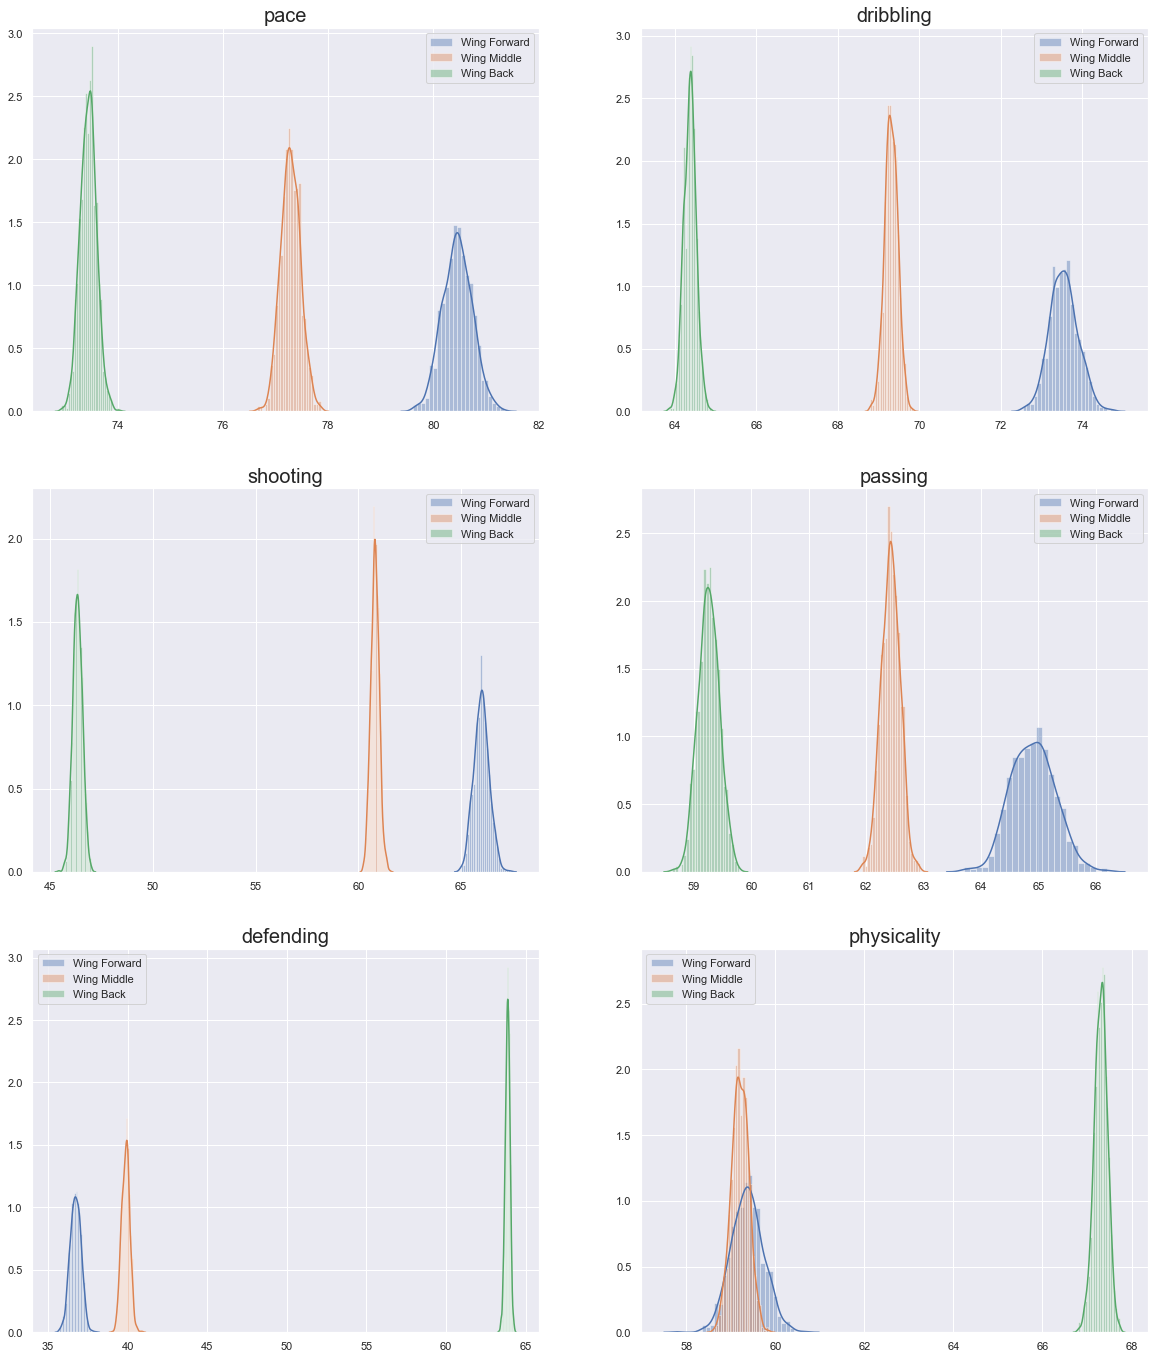

In [14]:
# WINGER

plt.figure(figsize=(20,24))
for num, skil in enumerate(skill):
    plt.subplot(3,2,num+1)
    for posisi in [i for i in fifa['position_area'].unique() if 'Wing' in i]:
        sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']==posisi][skil],'isi'), label=posisi)
    plt.title(skil, fontsize=20)
    plt.legend()

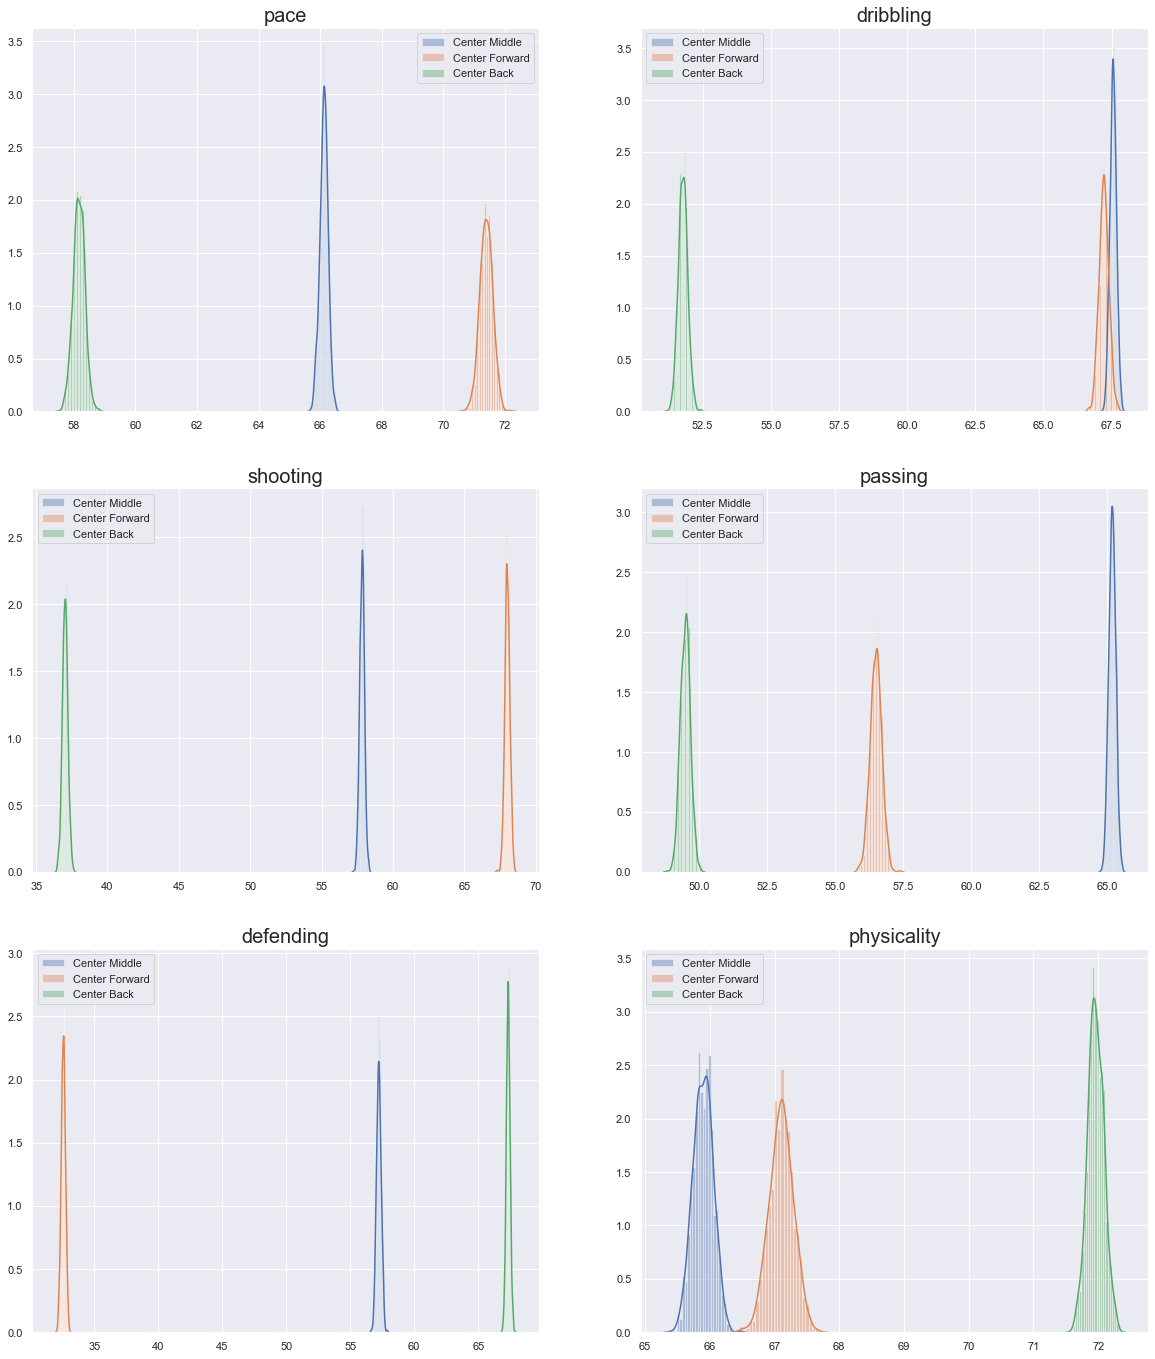

In [15]:
#CENTER

plt.figure(figsize=(20,24))
for num, skil in enumerate(skill):
    plt.subplot(3,2,num+1)
    for posisi in [i for i in fifa['position_area'].unique() if 'Center' in i]:
        sns.distplot(make_bootstrap(1000,fifa[fifa['position_area']==posisi][skil],'isi'), label=posisi)
    plt.title(skil, fontsize=20)
    plt.legend()

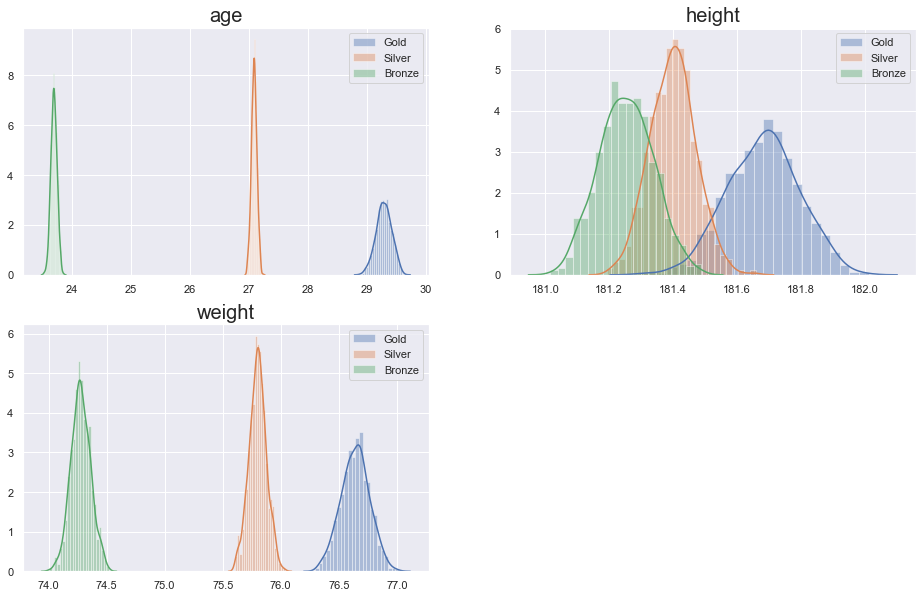

In [16]:
# Pengaruh umur, tinggi, dan berat badan terhadap quality cardnya
plt.figure(figsize=(16,10))
for num,i in enumerate(['age','height','weight']):
    plt.subplot(2,2,num+1)
    for j in fifa['quality'].unique():
        sns.distplot(make_bootstrap(1000, fifa[fifa['quality']==j][i], 'isi'), label=j)
        plt.legend()
    plt.title(i, fontsize=20)

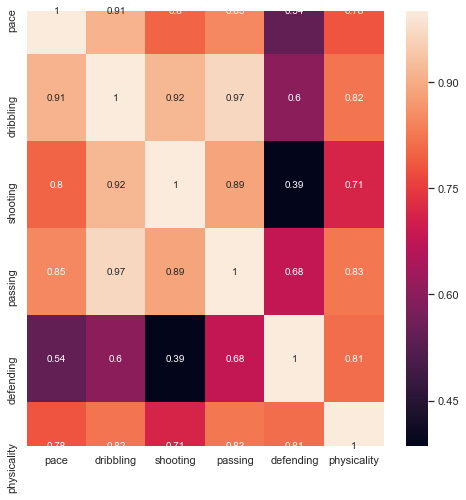

In [17]:
# Korelasi antar skill, dapat dilihat korelasinya cukup besar. Sehingga, model prediksi tidak menggunakan
# Linear Regression atau Logistic Regression
plt.figure(figsize=(8,8))
sns.heatmap(fifa[skill].corr(),annot=True)

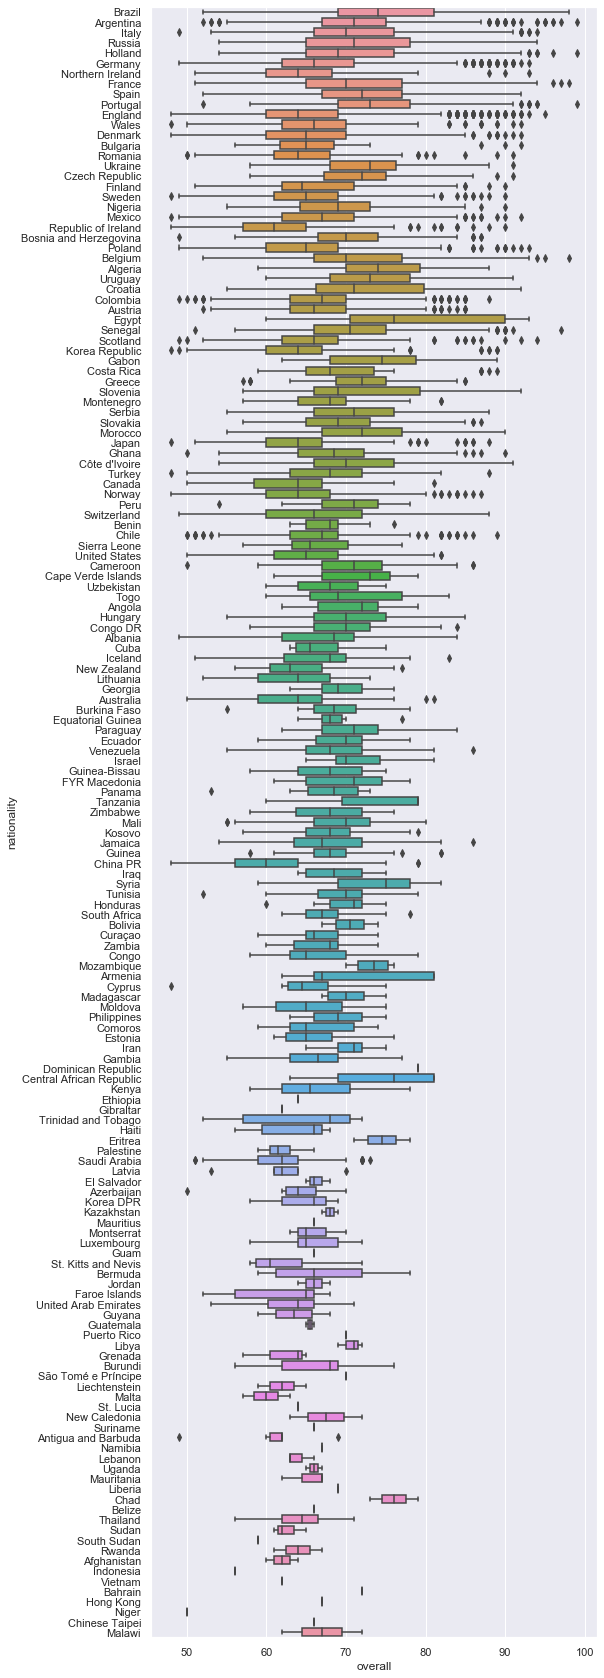

In [18]:
# Nilai overall untuk setiap negara
plt.figure(figsize=(8,30))
sns.boxplot(data=fifa[fifa['quality']!='Icons'], y='nationality', x='overall')

In [19]:
# Ada 1 pemain dari Indonesia
fifa[fifa['nationality']=='Indonesia']

,player_name,player_extended_name,quality,revision,overall,club,league,nationality,position,age,...,Comes for Crosses,Early Crosser,Injury Prone,Long Throw-In,Set Play Specialist,Rushes out of Goal,Cautious with Crosses,Saves with Feet,One Club Player,Giant Throw-in
14031,Maulana Vikri,Egy Maulana Vikri,Bronze,Normal,56,Lechia Gdańsk,Ekstraklasa,Indonesia,CAM,19,...,0,0,0,0,0,0,0,0,0,0


### Feature Importance

In [20]:
# Besarnya pengaruh julukkan dalam menentukan posisi area dengan nilai cramers_v
kate=[]
cram=[]
for i in jenis:
    kate.append(i)
    cram.append(cramers_v(fifa[i],fifa['position_area']))
df=pd.DataFrame({'Column':kate,'Cramers_V':cram})
df.sort_values(by=['Cramers_V'], ascending=False)

,Column,Cramers_V
17,Comes for Crosses,0.348968
7,Speed Dribbler (CPU AI Only),0.341868
4,Technical Dribbler (CPU AI Only),0.298757
3,Playmaker (CPU AI Only),0.290212
16,GK Long Throw,0.284059
13,Power Header,0.275063
23,Cautious with Crosses,0.273351
5,Flair,0.267239
22,Rushes out of Goal,0.254241
12,Long Shot Taker (CPU AI Only),0.228444


# Position Area Prediction Model
### Metode yang akan digunakan Random Forest, Boosting ,dan PCA

In [22]:
# Pengambilan data-data yang akan digunakkan untuk splitting data
kolom_posisi=[i for i in everything]
for i in jenis:
    kolom_posisi.append(i)
data_posisi=fifa[kolom_posisi]
target_posisi=fifa['position_area']

### Random Forest Classifier

In [23]:
# Splitting data untuk train dan test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data_posisi, target_posisi, test_size=0.30, random_state=101)

In [24]:
from sklearn.ensemble import RandomForestClassifier
fifa_rfc=RandomForestClassifier(n_estimators=1000)
fifa_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import classification_report

prediksi_posisi=fifa_rfc.predict(x_test)
print(classification_report(y_test, prediksi_posisi))

                precision    recall  f1-score   support

   Center Back       0.92      0.92      0.92       973
Center Forward       0.87      0.91      0.89       857
 Center Middle       0.83      0.89      0.86      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.89      0.89      0.89       836
  Wing Forward       0.65      0.22      0.33       245
   Wing Middle       0.67      0.68      0.68       688

      accuracy                           0.86      5633
     macro avg       0.83      0.79      0.79      5633
  weighted avg       0.85      0.86      0.85      5633



### AdaBoost

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

dt=DecisionTreeClassifier()
ada=AdaBoostClassifier(base_estimator=dt, n_estimators=1000, learning_rate=0.05, algorithm='SAMME')
ada.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [27]:
ada_predict=ada.predict(x_test)
print(classification_report(y_test,ada_predict))

                precision    recall  f1-score   support

   Center Back       0.84      0.86      0.85       973
Center Forward       0.82      0.84      0.83       857
 Center Middle       0.76      0.76      0.76      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.80      0.76      0.78       836
  Wing Forward       0.33      0.32      0.32       245
   Wing Middle       0.53      0.52      0.53       688

      accuracy                           0.77      5633
     macro avg       0.73      0.73      0.73      5633
  weighted avg       0.77      0.77      0.77      5633



### GradientBoost

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

grad=GradientBoostingClassifier(learning_rate=0.01, subsample=0.5, n_estimators=1000)
grad.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
grad_predict=grad.predict(x_test)
print(classification_report(y_test,grad_predict))

                precision    recall  f1-score   support

   Center Back       0.92      0.91      0.92       973
Center Forward       0.87      0.92      0.90       857
 Center Middle       0.84      0.88      0.86      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.88      0.91      0.89       836
  Wing Forward       0.52      0.23      0.32       245
   Wing Middle       0.64      0.64      0.64       688

      accuracy                           0.85      5633
     macro avg       0.81      0.78      0.79      5633
  weighted avg       0.84      0.85      0.84      5633



### XGBoost

In [30]:
from xgboost import XGBClassifier

xgboost=XGBClassifier(learning_rate=0.01, n_estimators=1000, max_dept=4, n_jobs=-1)
xgboost.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_dept=4, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [31]:
xgboost_predict=xgboost.predict(x_test)
print(classification_report(y_test, xgboost_predict))

                precision    recall  f1-score   support

   Center Back       0.92      0.91      0.92       973
Center Forward       0.88      0.92      0.90       857
 Center Middle       0.85      0.88      0.86      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.89      0.90      0.90       836
  Wing Forward       0.48      0.20      0.28       245
   Wing Middle       0.66      0.69      0.67       688

      accuracy                           0.85      5633
     macro avg       0.81      0.79      0.79      5633
  weighted avg       0.85      0.85      0.85      5633



### PCA

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
scaled_train=scaler.transform(x_train)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(scaled_train)
pca_train=pca.transform(scaled_train)

In [34]:
rfc_pca=RandomForestClassifier()
rfc_pca.fit(pca_train, y_train)

scaled_test=scaler.transform(x_test)
pca_test=pca.transform(scaled_test)
predict_pca=rfc_pca.predict(pca_test)

print(classification_report(y_test, predict_pca))

                precision    recall  f1-score   support

   Center Back       0.89      0.88      0.88       973
Center Forward       0.84      0.88      0.86       857
 Center Middle       0.73      0.83      0.78      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.79      0.77      0.78       836
  Wing Forward       0.49      0.19      0.28       245
   Wing Middle       0.59      0.54      0.57       688

      accuracy                           0.79      5633
     macro avg       0.76      0.73      0.73      5633
  weighted avg       0.78      0.79      0.78      5633



### Position Area Prediction Model Evaluation

In [35]:
print('\t\t\tRANDOM FOREST')
print(classification_report(y_test, prediksi_posisi))
print('\t\t\tADA BOOSTING')
print(classification_report(y_test, ada_predict))
print('\t\t\tGRADIENT BOOSTING')
print(classification_report(y_test, grad_predict))
print('\t\t\tXGBOOST')
print(classification_report(y_test, xgboost_predict))
print('\t\t\tPCA')
print(classification_report(y_test, predict_pca))

			RANDOM FOREST
                precision    recall  f1-score   support

   Center Back       0.92      0.92      0.92       973
Center Forward       0.87      0.91      0.89       857
 Center Middle       0.83      0.89      0.86      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.89      0.89      0.89       836
  Wing Forward       0.65      0.22      0.33       245
   Wing Middle       0.67      0.68      0.68       688

      accuracy                           0.86      5633
     macro avg       0.83      0.79      0.79      5633
  weighted avg       0.85      0.86      0.85      5633

			ADA BOOSTING
                precision    recall  f1-score   support

   Center Back       0.84      0.86      0.85       973
Center Forward       0.82      0.84      0.83       857
 Center Middle       0.76      0.76      0.76      1458
    Goalkeeper       1.00      1.00      1.00       576
     Wing Back       0.80      0.76      0.78       836
  Wing Forw

# Overall Prediction Model
### Metode menggunakan Boosting dan Random Forest

In [36]:
data_overall=fifa[everything].drop('pref_foot_Right', axis=1)
over=fifa['overall']

### Random Forest Regressor

In [37]:
X_train,X_test,Y_train,Y_test=train_test_split(data_overall, over, test_size=0.30, random_state=101)

In [38]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor()
rfr.fit(X_train,Y_train)
prediksi_rfr=rfr.predict(X_test)

In [39]:
from sklearn import metrics

print('MAE      : ',metrics.mean_absolute_error(Y_test, prediksi_rfr))
print('MSE      : ',metrics.mean_squared_error(Y_test, prediksi_rfr))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, prediksi_rfr)))
print('R2 Score : ',metrics.r2_score(Y_test, prediksi_rfr))

MAE      :  0.834599680454465
MSE      :  1.2769898100479316
RMSE     :  1.130039738260532
R2 Score :  0.9814794483970941


### AdaBoost Regressor

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

dtreg=DecisionTreeRegressor()
adareg=AdaBoostRegressor(base_estimator=dtreg, n_estimators=100, learning_rate=0.05)
adareg.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [42]:
adareg_predict=adareg.predict(X_test)

print('MAE      : ',metrics.mean_absolute_error(Y_test, adareg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, adareg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, adareg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, adareg_predict))

MAE      :  0.7630037280312445
MSE      :  1.3136872004260607
RMSE     :  1.1461619433684145
R2 Score :  0.9809472155579263


### Gradient Boost Regressor

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gradreg=GradientBoostingRegressor(learning_rate=0.01, subsample=0.5, n_estimators=100)
gradreg.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
gradreg_predict=gradreg.predict(X_test)

print('MAE      : ',metrics.mean_absolute_error(Y_test, gradreg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, gradreg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, gradreg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, gradreg_predict))

MAE      :  3.289506904539567
MSE      :  18.63464145943232
RMSE     :  4.316786010382298
R2 Score :  0.729736419166797


### XGBoost Regressor

In [45]:
from xgboost import XGBRegressor

xgbreg=XGBRegressor(learning_rate=0.01, n_estimators=100, max_dept=4, n_jobs=-1)
xgbreg.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_dept=4, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [46]:
xgbreg_predict=xgbreg.predict(X_test)

print('MAE      : ',metrics.mean_absolute_error(Y_test, xgbreg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, xgbreg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, xgbreg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, xgbreg_predict))

MAE      :  24.797471100454874
MSE      :  629.654437303296
RMSE     :  25.092916078114477
R2 Score :  -8.132059947789756


### Overall Prediction model evaluation

In [49]:
print('\tRANDOM FOREST REGRESSOR')
print('MAE      : ',metrics.mean_absolute_error(Y_test, prediksi_rfr))
print('MSE      : ',metrics.mean_squared_error(Y_test, prediksi_rfr))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, prediksi_rfr)))
print('R2 Score : ',metrics.r2_score(Y_test, prediksi_rfr))
print('\n\tADA BOOST REGRESSOR')
print('MAE      : ',metrics.mean_absolute_error(Y_test, adareg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, adareg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, adareg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, adareg_predict))
print('\n\tGRADIENT BOOST REGRESSOR')
print('MAE      : ',metrics.mean_absolute_error(Y_test, gradreg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, gradreg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, gradreg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, adareg_predict))
print('\n\tXGBOOST REGRESSOR')
print('MAE      : ',metrics.mean_absolute_error(Y_test, xgbreg_predict))
print('MSE      : ',metrics.mean_squared_error(Y_test, xgbreg_predict))
print('RMSE     : ', np.sqrt(metrics.mean_squared_error(Y_test, xgbreg_predict)))
print('R2 Score : ',metrics.r2_score(Y_test, xgbreg_predict))

	RANDOM FOREST REGRESSOR
MAE      :  0.834599680454465
MSE      :  1.2769898100479316
RMSE     :  1.130039738260532
R2 Score :  0.9814794483970941

	ADA BOOST REGRESSOR
MAE      :  0.7630037280312445
MSE      :  1.3136872004260607
RMSE     :  1.1461619433684145
R2 Score :  0.9809472155579263

	GRADIENT BOOST REGRESSOR
MAE      :  3.289506904539567
MSE      :  18.63464145943232
RMSE     :  4.316786010382298
R2 Score :  0.9809472155579263

	XGBOOST REGRESSOR
MAE      :  24.797471100454874
MSE      :  629.654437303296
RMSE     :  25.092916078114477
R2 Score :  -8.132059947789756
